# CV_PROJECT: IMAGE COLORIZATION

TEAM Members: 
1) Vivek Reddy A
2) Amogh Bedarakota
3) Muni Bhavana 
4) Naga Sri Hita Veleti

In [687]:
batch_size = 5
num_workers = 2
seed = 814

In [688]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [689]:
BAVS_dataset_folder = "/content/drive/MyDrive/CV_project_dataset"
MODEL_SAVE_PATH = '/content/drive/MyDrive/CV_project_dataset'

In [671]:
%pip install fastai

In [672]:
import os, shutil, sys

BAVS_DATA_DIR = BAVS_dataset_folder

TRAIN_DATASET_PATH = os.path.join(BAVS_DATA_DIR, 'Dataset')
VAL_DATASET_PATH = os.path.join(BAVS_DATA_DIR, 'validation')
TEST_DATASET_PATH = os.path.join(BAVS_DATA_DIR, 'test_1')


# DATASET LOADER

In [673]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

class BAVS_Dataset(Dataset):
    def __init__(self, ALL_IMG_PATH, BASE_PATH, purpose):
        assert(purpose in ['train', 'val', 'test'])
        self.H = 512  # Height updated
        self.W = 512  # Width updated, assuming you want a square image
        self.purpose = purpose
        self.ALL_IMG_PATH = ALL_IMG_PATH
        self.BASE_PATH = BASE_PATH

    def __len__(self):
        return len(self.ALL_IMG_PATH)

    def __getitem__(self, index):
        c_image_path = os.path.join(self.BASE_PATH, self.ALL_IMG_PATH[index])
        img = Image.open(c_image_path).convert('RGB')

        # Resize image without using transforms
        img = img.resize((self.H, self.W), Image.BICUBIC)

        img = np.array(img)

        # Convert RGB to LAB
        lab_img = torch.from_numpy(rgb2lab(img)).float().permute(2,0,1)

        L_ch = lab_img[[0], ...] / 50.0 - 1.0
        AB_ch = lab_img[[1,2], ...] / 110.0

        return (L_ch, AB_ch)


In [674]:
train_imgs = os.listdir(TRAIN_DATASET_PATH)
train_Dataset = BAVS_Dataset(ALL_IMG_PATH = train_imgs, BASE_PATH=TRAIN_DATASET_PATH,
                             purpose='train')
train_dataloader = DataLoader(train_Dataset, batch_size = batch_size, shuffle=True,
                              num_workers = num_workers, pin_memory=True, drop_last=True)

val_imgs = sorted(os.listdir(VAL_DATASET_PATH))
val_Dataset = BAVS_Dataset(ALL_IMG_PATH = val_imgs, BASE_PATH=VAL_DATASET_PATH,
                             purpose='val')
val_dataloader = DataLoader(val_Dataset, batch_size = batch_size, shuffle=False,
                              num_workers = num_workers, pin_memory=True, drop_last=True)


In [675]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(seed)

# GENERATOR

In [676]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    """
    A Block handling either downsampling with Conv2d or upsampling with ConvTranspose2d,
    including optional dropout and using LeakyReLU for downsampling and ReLU for upsampling.
    """
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super(Block, self).__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, features=64):
        super(Generator, self).__init__()
        # Downsampling Path
        self.downs = nn.ModuleList([
            Block(in_channels, features, down=True, use_dropout=False),
            Block(features, features * 2, down=True, use_dropout=False),
            Block(features * 2, features * 4, down=True, use_dropout=False),
            Block(features * 4, features * 8, down=True, use_dropout=False),
            Block(features * 8, features * 8, down=True, use_dropout=False),
            Block(features * 8, features * 8, down=True, use_dropout=False),  # Additional bottleneck layer
        ])

        # Upsampling Path
        self.ups = nn.ModuleList([
            Block(features * 8, features * 8, down=False, use_dropout=True),
            Block(features * 16, features * 8, down=False, use_dropout=True),
            Block(features * 16, features * 4, down=False, use_dropout=True),
            Block(features * 8, features * 2, down=False, use_dropout=False),
            Block(features * 4, features, down=False, use_dropout=False),
        ])

        # Final Upsample to get to the original dimensions but with 2 output channels
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)

        skip_connections = skip_connections[::-1][1:]  # Reverse for upsampling and exclude extra bottleneck

        # Upsampling
        for idx, up in enumerate(self.ups):
            x = up(x)
            skip_connection = skip_connections[idx]
            x = torch.cat((x, skip_connection), dim=1)

        return self.final_up(x)


# Patch_Discriminator

In [677]:
import torch
from torch import nn

class Patch_Discriminator(nn.Module):
    def __init__(self, input_c=3):
        super(Patch_Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Initial layer
            nn.Conv2d(input_c, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Increasing the number of layers
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Additional layer
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Final layer reduced to a small patch size
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)



patch_discriminator = Patch_Discriminator(input_c=3)
print(patch_discriminator)


Patch_Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momen

In [678]:
discriminator = Patch_Discriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape
# Loss
class loss_GAN(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def calculate_loss(self, pred, isreal):
        gt_label = None
        if isreal == True:
            gt_label = torch.ones_like(pred, dtype=pred.dtype, device=pred.device)
        else:
            gt_label = torch.zeros_like(pred, dtype=pred.dtype, device=pred.device)
        return self.loss(pred, gt_label)

In [679]:
def denorm_l_channel(l_channel):
    return (l_channel + 1.0) * 50.0

def denorm_ab_channel(ab_channel):
    return ab_channel * 110.0

# GAN_TRAINING MODEL

In [680]:
class Patch_GAN(nn.Module):
    def __init__(self, Gen_model, Disc_model, lr, loss_lambda=100.):
        super().__init__()
        # Set the device to CUDA if available, else CPU
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Define loss functions and a scaling factor for the L1 loss
        self.l1_loss = nn.L1Loss()
        self.GAN_loss = loss_GAN()
        self.loss_lambda = loss_lambda

        # Initialize the generator and discriminator models and move them to the correct device
        self.Gen_model = self.initialize_and_to_device(Gen_model, self.device)
        self.Disc_model = self.initialize_and_to_device(Disc_model, self.device)

        # Define RMSprop optimizers for the generator and discriminator
        self.optim_Generator = optim.RMSprop(self.Gen_model.parameters(), lr=lr)
        self.optim_Discriminator = optim.RMSprop(self.Disc_model.parameters(), lr=lr)
        self.optim_Generator_only = optim.RMSprop(self.Gen_model.parameters(), lr=lr)

    def forward(self, l_channel):
        # Forward pass through the generator
        return self.Gen_model(l_channel)

    def control_grad(self, model, flag):
        # Enable or disable requires_grad to freeze or unfreeze model parameters
        for param in model.parameters():
            param.requires_grad = flag

    def train_(self, l_channel, ab_channel):
        # Transfer input data to the appropriate device
        l_channel = l_channel.to(self.device)
        ab_channel = ab_channel.to(self.device)

        # Generate fake color channels
        fake_ab = self.forward(l_channel)

        # Set the discriminator to training mode
        self.Disc_model.train()
        self.control_grad(self.Disc_model, flag=True)
        self.optim_Discriminator.zero_grad()

        # Calculate discriminator losses on both real and fake images
        gt_img = torch.cat((l_channel, ab_channel), dim=1)
        fake_img = torch.cat((l_channel, fake_ab), dim=1)
        D_pred_fake = self.Disc_model(fake_img.detach())
        D_loss_fake = self.GAN_loss.calculate_loss(pred=D_pred_fake, isreal=False)
        D_pred_gt = self.Disc_model(gt_img)
        D_loss_real = self.GAN_loss.calculate_loss(pred=D_pred_gt, isreal=True)

        # Calculate total discriminator loss and perform backpropagation
        D_loss_total = 0.5 * D_loss_fake + 0.5 * D_loss_real
        D_loss_total.backward()
        self.optim_Discriminator.step()

        # Set the generator to training mode and freeze the discriminator
        self.Gen_model.train()
        self.control_grad(self.Disc_model, flag=False)
        self.optim_Generator.zero_grad()

        # Calculate generator loss using discriminator's feedback
        G_pred_fake = self.Disc_model(fake_img)
        G_loss_GAN = self.GAN_loss.calculate_loss(pred=G_pred_fake, isreal=True)
        G_loss_L1 = self.l1_loss(fake_ab, ab_channel)
        G_loss_total = G_loss_GAN + G_loss_L1 * self.loss_lambda
        G_loss_total.backward()
        self.optim_Generator.step()

        return [D_loss_fake.cpu().item(), D_loss_real.cpu().item(), D_loss_total.cpu().item(),
                G_loss_GAN.cpu().item(), G_loss_L1.cpu().item(), G_loss_total.cpu().item()]

    def visualize(self, l_channel, ab_channel, epoch=0):
        # Visualization method to show grayscale inputs, generated fake images, and ground truth
        l_channel = l_channel.to(self.device)
        ab_channel = ab_channel.to(self.device)
        self.Gen_model.eval()
        with torch.no_grad():
            fake_ab = self.forward(l_channel).detach()
            fake_img_lab = torch.cat((denorm_l_channel(l_channel), denorm_ab_channel(fake_ab)), dim=1)
            gt_img_lab = torch.cat((denorm_l_channel(l_channel), denorm_ab_channel(ab_channel)), dim=1)

            fake_img_rgb = lab2rgb(fake_img_lab.permute(0, 2, 3, 1).cpu().numpy())
            gt_img_rgb = lab2rgb(gt_img_lab.permute(0, 2, 3, 1).cpu().numpy())

        self.Gen_model.train()
        num_images = min(5, l_channel.size(0))  # Display up to 5 images

        plt.figure(figsize=(15, 3 * num_images))
        for i in range(min(5, l_channel.size(0))):
            plt.subplot(num_images, 3, i * 3 + 1)
            plt.imshow(l_channel[i].cpu().squeeze(), cmap='gray')
            plt.title('Grayscale Input')
            plt.axis('off')

            plt.subplot(num_images, 3, i * 3 + 2)
            plt.imshow(fake_img_rgb[i])
            plt.title('Generated Fake')
            plt.axis('off')

            plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(gt_img_rgb[i])
            plt.title('Ground Truth')
            plt.axis('off')

        plt.show()

    def save_model(self, save_path, epoch):
        # Save the model parameters and optimizers
        save_path = os.path.join(save_path, f'epoch={epoch}.pt')
        torch.save({
            'epoch': epoch,
            'G_state_dict': self.Gen_model.state_dict(),
            'D_state_dict': self.Disc_model.state_dict(),
            'opt_G_state_dict': self.optim_Generator.state_dict(),
            'opt_D_state_dict': self.optim_Discriminator.state_dict(),
        }, save_path)

    def load_model(self, load_DIR):
        # Load model parameters and optimizers
        CHECKPOINT = torch.load(load_DIR)
        self.Gen_model.load_state_dict(CHECKPOINT['G_state_dict'])
        self.Disc_model.load_state_dict(CHECKPOINT['D_state_dict'])
        self.optim_Generator.load_state_dict(CHECKPOINT['opt_G_state_dict'])
        self.optim_Discriminator.load_state_dict(CHECKPOINT['opt_D_state_dict'])

    def weight_initialization(self, model):
        # Initialize weights using Xavier uniform initialization
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        return model

    def initialize_and_to_device(self, model, device):
        # Move model to device and initialize weights
        model = model.to(device)
        model = self.weight_initialization(model)
        return model

    def train_generator_only(self, l_channel, ab_channel):
        # Train only the generator on a given pair of l_channel and ab_channel
        self.Gen_model.train()
        l_channel = l_channel.to(self.device)
        ab_channel = ab_channel.to(self.device)
        self.optim_Generator_only.zero_grad()
        fake_ab = self.forward(l_channel)
        G_loss = self.l1_loss(fake_ab, ab_channel)
        G_loss.backward()
        self.optim_Generator_only.step()
        return G_loss.cpu().item()


In [681]:
import os
import numpy as np
from tqdm import tqdm

def train_model(model, epochs, visualization_interval=5):
    # Load a single batch for visualization purposes
    vis_batch = next(iter(val_dataloader))
    vis_l, vis_ab = vis_batch

    # Initialize logging
    loss_log = []
    loss_log_dir = os.path.join(MODEL_SAVE_PATH, 'loss_log.npy')

    # Training loop
    for epoch in range(epochs):
        current_epoch_losses = []

        # Iterate through the training data loader
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            l_channel, ab_channel = batch
            generator_loss = model.train_generator_only(l_channel, ab_channel)
            current_epoch_losses.append(generator_loss)

        # Compute and log the average loss for the epoch
        avg_epoch_loss = np.mean(current_epoch_losses)
        loss_log.append(avg_epoch_loss)
        np.save(loss_log_dir, np.array(loss_log))

        # Print average loss for the current epoch
        print(f"Average Loss for Epoch {epoch+1}: {avg_epoch_loss}")

        # Visualization and model checkpointing at specified intervals
        if (epoch + 1) % visualization_interval == 0 or epoch == 0:
            visualize_and_save(model, epoch, vis_l, vis_ab)

def visualize_and_save(model, epoch, l_channel, ab_channel):
    """Helper function to visualize model output and save the model."""
    print(f'Visualizing and Saving Model - Epoch: {epoch+1}')
    model.visualize(l_channel, ab_channel, epoch)
    model.save_model(MODEL_SAVE_PATH, epoch)



# TRAINING

Epoch 1/1: 100%|██████████| 723/723 [02:35<00:00,  4.66it/s]
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 196 pixels
  return func(*args, **kwargs)


Average Loss for Epoch 1: 0.1454821328837347
Visualizing and Saving Model - Epoch: 1


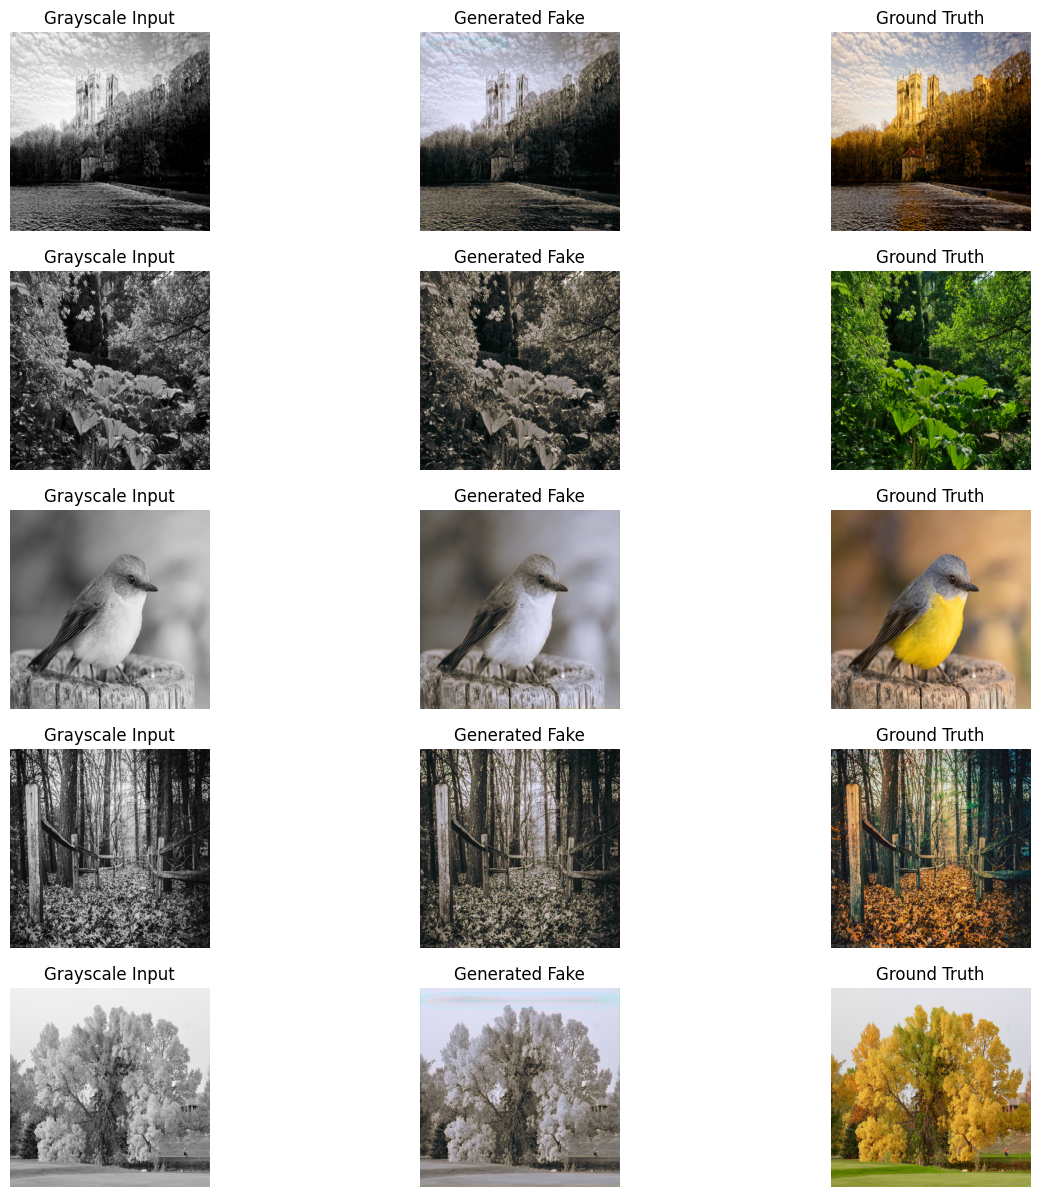

In [682]:
Gen_model = Generator(1, 2, )
Disc_model = Patch_Discriminator(3)
model = Patch_GAN(Gen_model, Disc_model, 1e-4)
train_model(model, 70)

# Visualize using Pretrained Model

In [685]:
from torchvision import transforms

batch_size = 5
num_workers = 8


train_imgs = ['0001360.png', '0000058.png', '0000131.png', '0000165.png', '0000365.png']
train_Dataset = BAVS_Dataset(ALL_IMG_PATH = train_imgs, BASE_PATH=TRAIN_DATASET_PATH,
                             purpose='train', )
train_dataloader = DataLoader(train_Dataset, batch_size = batch_size, shuffle=False,
                              num_workers = num_workers, pin_memory=True, drop_last=True)

val_imgs = ['0072827.png', '0070153.png', '0073856.png', '0070082.png','0070195.png']
val_Dataset = BAVS_Dataset(ALL_IMG_PATH = val_imgs, BASE_PATH=VAL_DATASET_PATH,
                             purpose='val', )
val_dataloader = DataLoader(val_Dataset, batch_size = batch_size, shuffle=False,
                              num_workers = num_workers, pin_memory=True, drop_last=True)

test_imgs = ['0070560.png', '0070676.png','0070929.png', '0071195.png','0070130.png']
test_Dataset = BAVS_Dataset(ALL_IMG_PATH = test_imgs, BASE_PATH=TEST_DATASET_PATH,
                             purpose='test', )
test_dataloader = DataLoader(test_Dataset, batch_size = batch_size, shuffle=False,
                              num_workers = num_workers, pin_memory=True, drop_last=True)

training set


  0%|          | 0/1 [00:00<?, ?it/s]

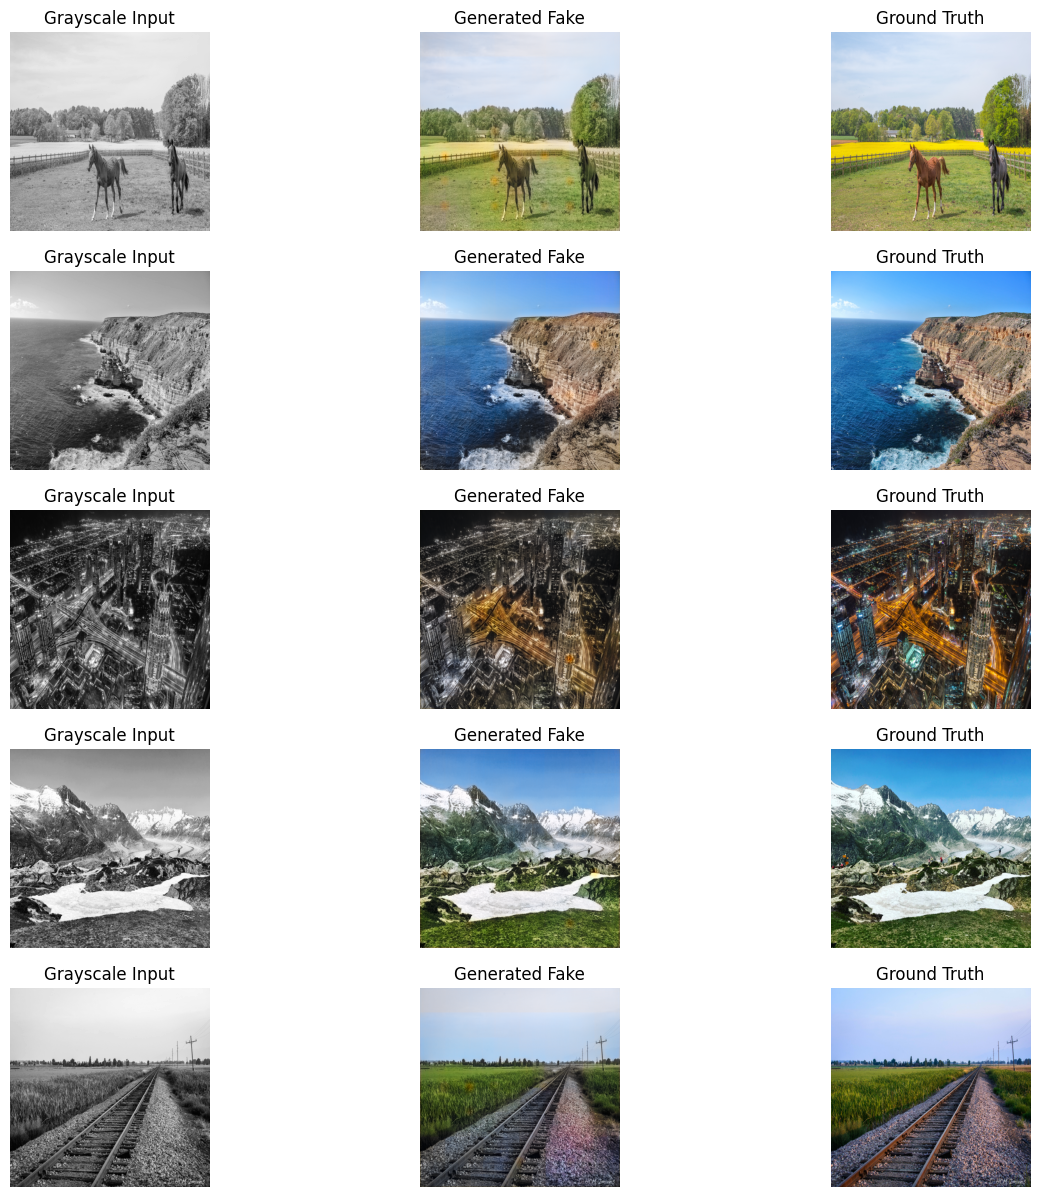

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


validation set


  0%|          | 0/1 [00:00<?, ?it/s]

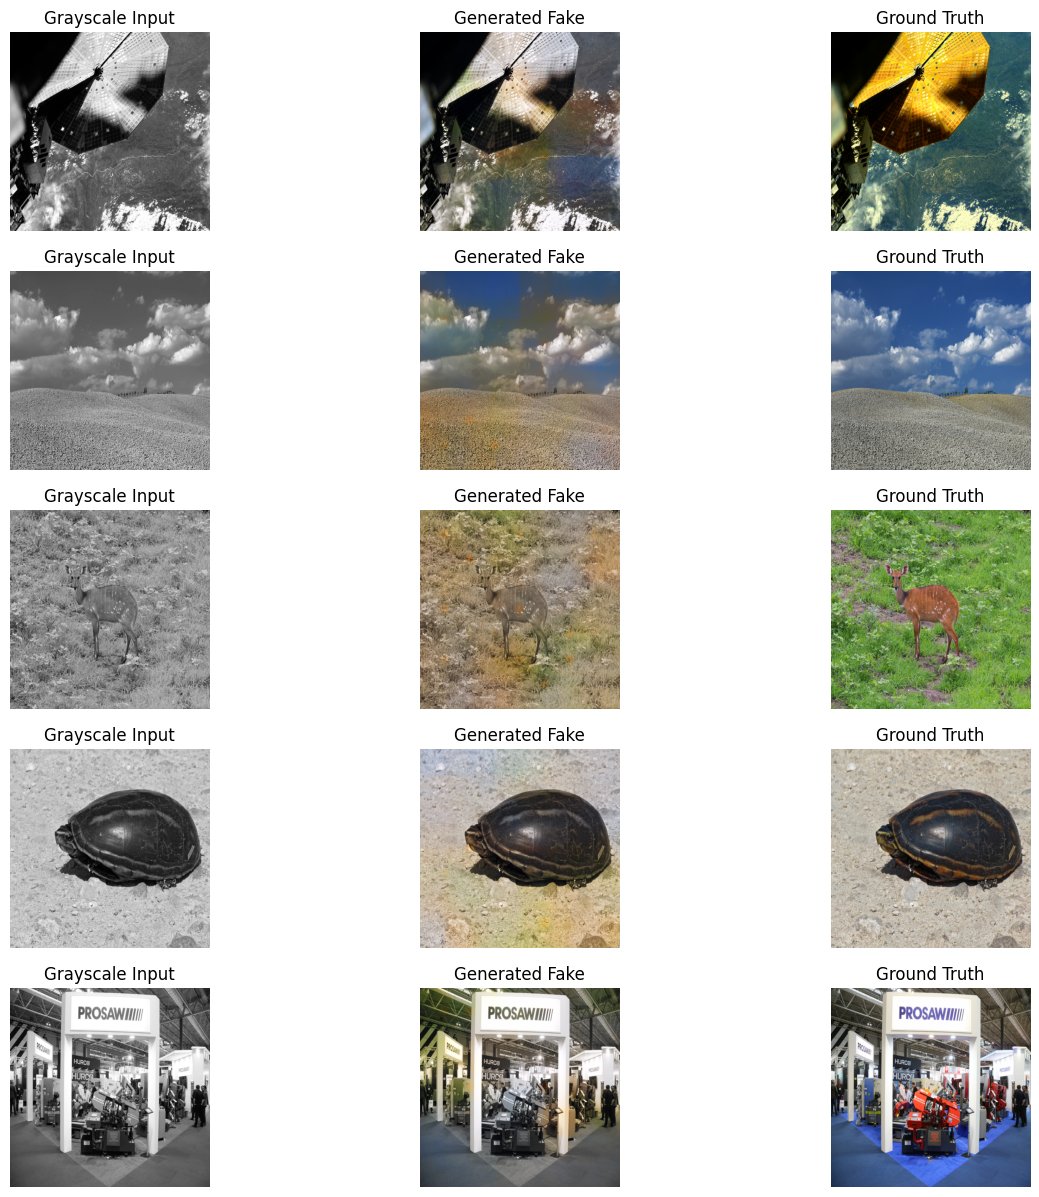

100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


test set


  0%|          | 0/1 [00:00<?, ?it/s]

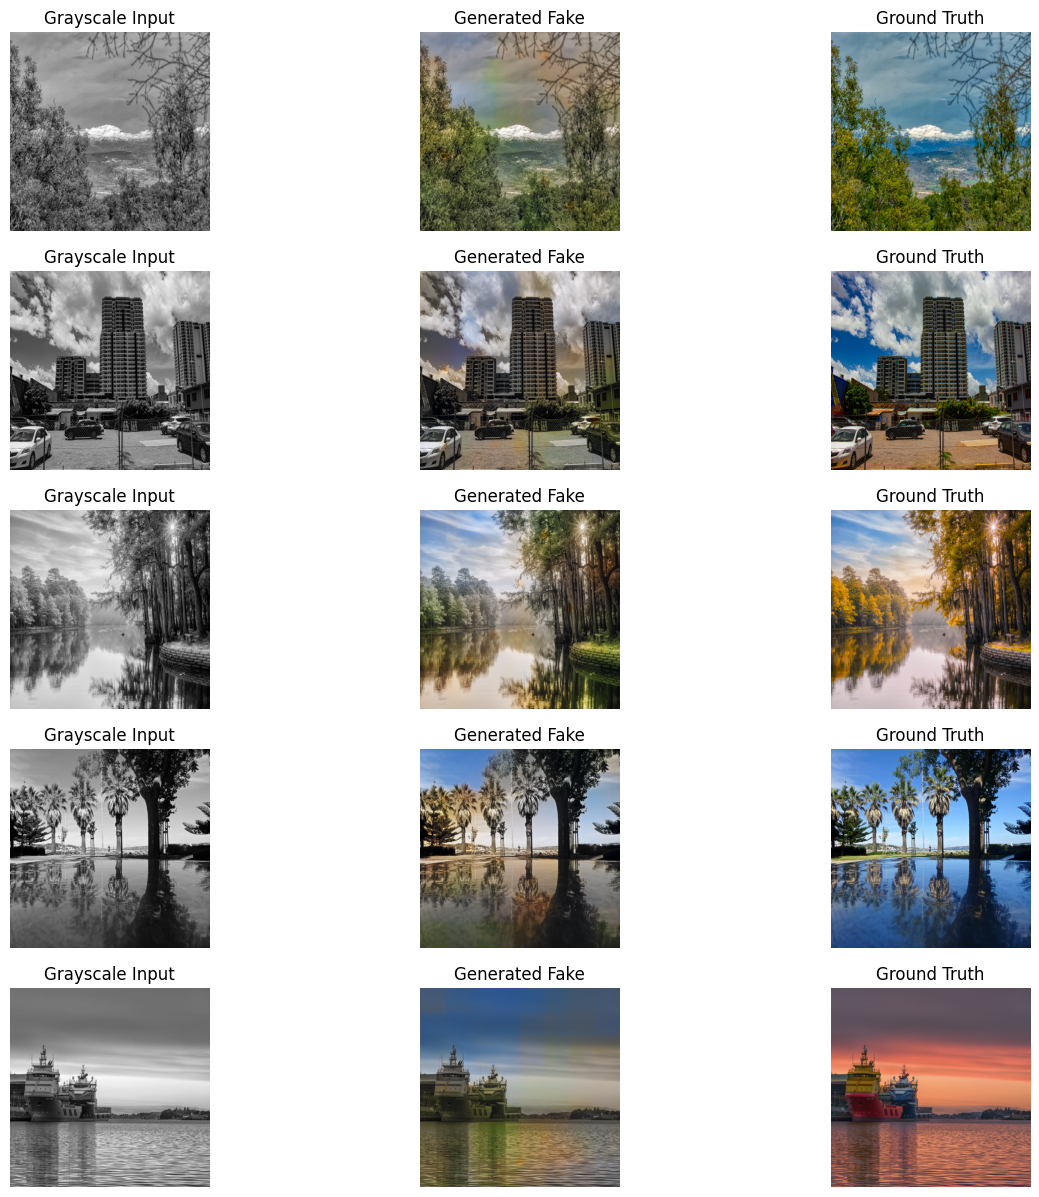

100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


In [690]:
print("training set")
for c_data in tqdm(train_dataloader):
    vis_l, vis_ab = c_data
    model.load_model('/content/drive/MyDrive/CV_project_dataset/pretrained.pt')
    model.visualize(vis_l, vis_ab)

print("validation set")
for c_data in tqdm(val_dataloader):
    vis_l, vis_ab = c_data
    model.load_model('/content/drive/MyDrive/CV_project_dataset/pretrained.pt')
    model.visualize(vis_l, vis_ab)

print("test set")
for c_data in tqdm(test_dataloader):
    vis_l, vis_ab = c_data
    model.visualize(vis_l, vis_ab)